# GANocracy 2019: Democratizing GAN training for all

**Author**: `Alex Andonian`

## Introduction

This tutorial will give a brief introduction to some of the more recent achievements of Generative Adversarial Networks (GANs), which have seen tremendous progress in their short 5 year lifespan.
https://twitter.com/goodfellow_ian/status/1084973596236144640/photo/1

As impressive as these results are, training the latest state-of-the-art GANs isn't without its challenges. For example GANs are still: 
 - sensitivive to structure and parameters/configuration
 - susceptible to model collapse
 - demanding on computational resources, especially for larger resolutions
 
The goal of this tutorial is to prepare users to take on the task of training large-scale, high-resolution GANs of their own. We will begin training a simplified version of the recent BigGAN architecture and walk through some techniques for monitoring and debugging the training process. Finally, we will demonstrate how to control sample generation using a fully pretrained BigGAN.

This tutorial assumes a basic understanding of GANs as well as a machine ready to run the latest release of PyTorch (1.1). For a general overview of GANs and how they work, please refer to [Insert Introduction Link]. For more detailed instructions on how to install PyTorch, please see these instructions [Insert Link to Setup.md].


## Setup Environment

### System Requirements

### Software Requriements

### Recommendations


In [15]:
# IMPORTS
import os 
import sys
import numpy as np
import torch
import torch.nn as nn

# GANOCRACY LIB
sys.path.append('../')
import ganocracy
from ganocracy.data import datasets as dset
from ganocracy.data import transforms
from ganocracy.utils import visualizer as vutils

# NOTEBOOK-SPECIFIC IMPORTS
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [16]:
config = {

    # DATA CONFIG
    'data_root': 'data',            # Root directory where datasets are stored
    'dataset': 'satellite_images',  # Name of dataset 
    'parallel': True,
    'shuffle': True,                # Shuffle training data
    'batch_size': 128,              
    'num_workers': 24,
    'load_in_mem': True,
    'resolution': 128,
    
    # MODEL ARCHITECTURE
    'G_ch': 96,
    'D_ch': 96,
    'G_attn': 64,
    'D_attn': 64,
    'hier': True,
    'dim_z': 120,
    'shared_dim': 128,
    'G_init': 'ortho',
    'D_init': 'ortho',
    'G_n1': 'inplace_relu',
    'D_n1': 'inplace_relu',
    'G_eval_mode': True,
    
    # TRAINING CONFIG     
    'num_D_steps': 1,
    'num_G_accumulations': 4,
    'num_D_accumulations': 4,
    'G_lr': 1e-4,
    'D_lr': 4e-4,
    'D_B2': 0.999,
    'G_B2': 0.999,

    'ema': True,
    'use_ema': True,
    'ema_start': 20000,
    'test_every': 2000,
    'save_every': 1000,
    'num_best_copies': 5,
    'num_save_copies': 2,
    'seed': 0,
    'use_multiepoch_sampler': True,
}

## Data Preparation
In this tutorial, we will use the [Places365 dataset](http://places2.csail.mit.edu/) which contains more than 10 million images comprising 400+ unique scene categories. You can manually download the full dataset [here](http://places2.csail.mit.edu/download.html), although we provide standard PyTorch dataloaders that download, cache and preprocess several standard datasets as part of this tutorial. Therefore, preparing a dataloader can be accomplished with just a few lines:

Data found at: data/satellite_images
Loading pre-saved index file data/satellite_images/satellite_images.npz


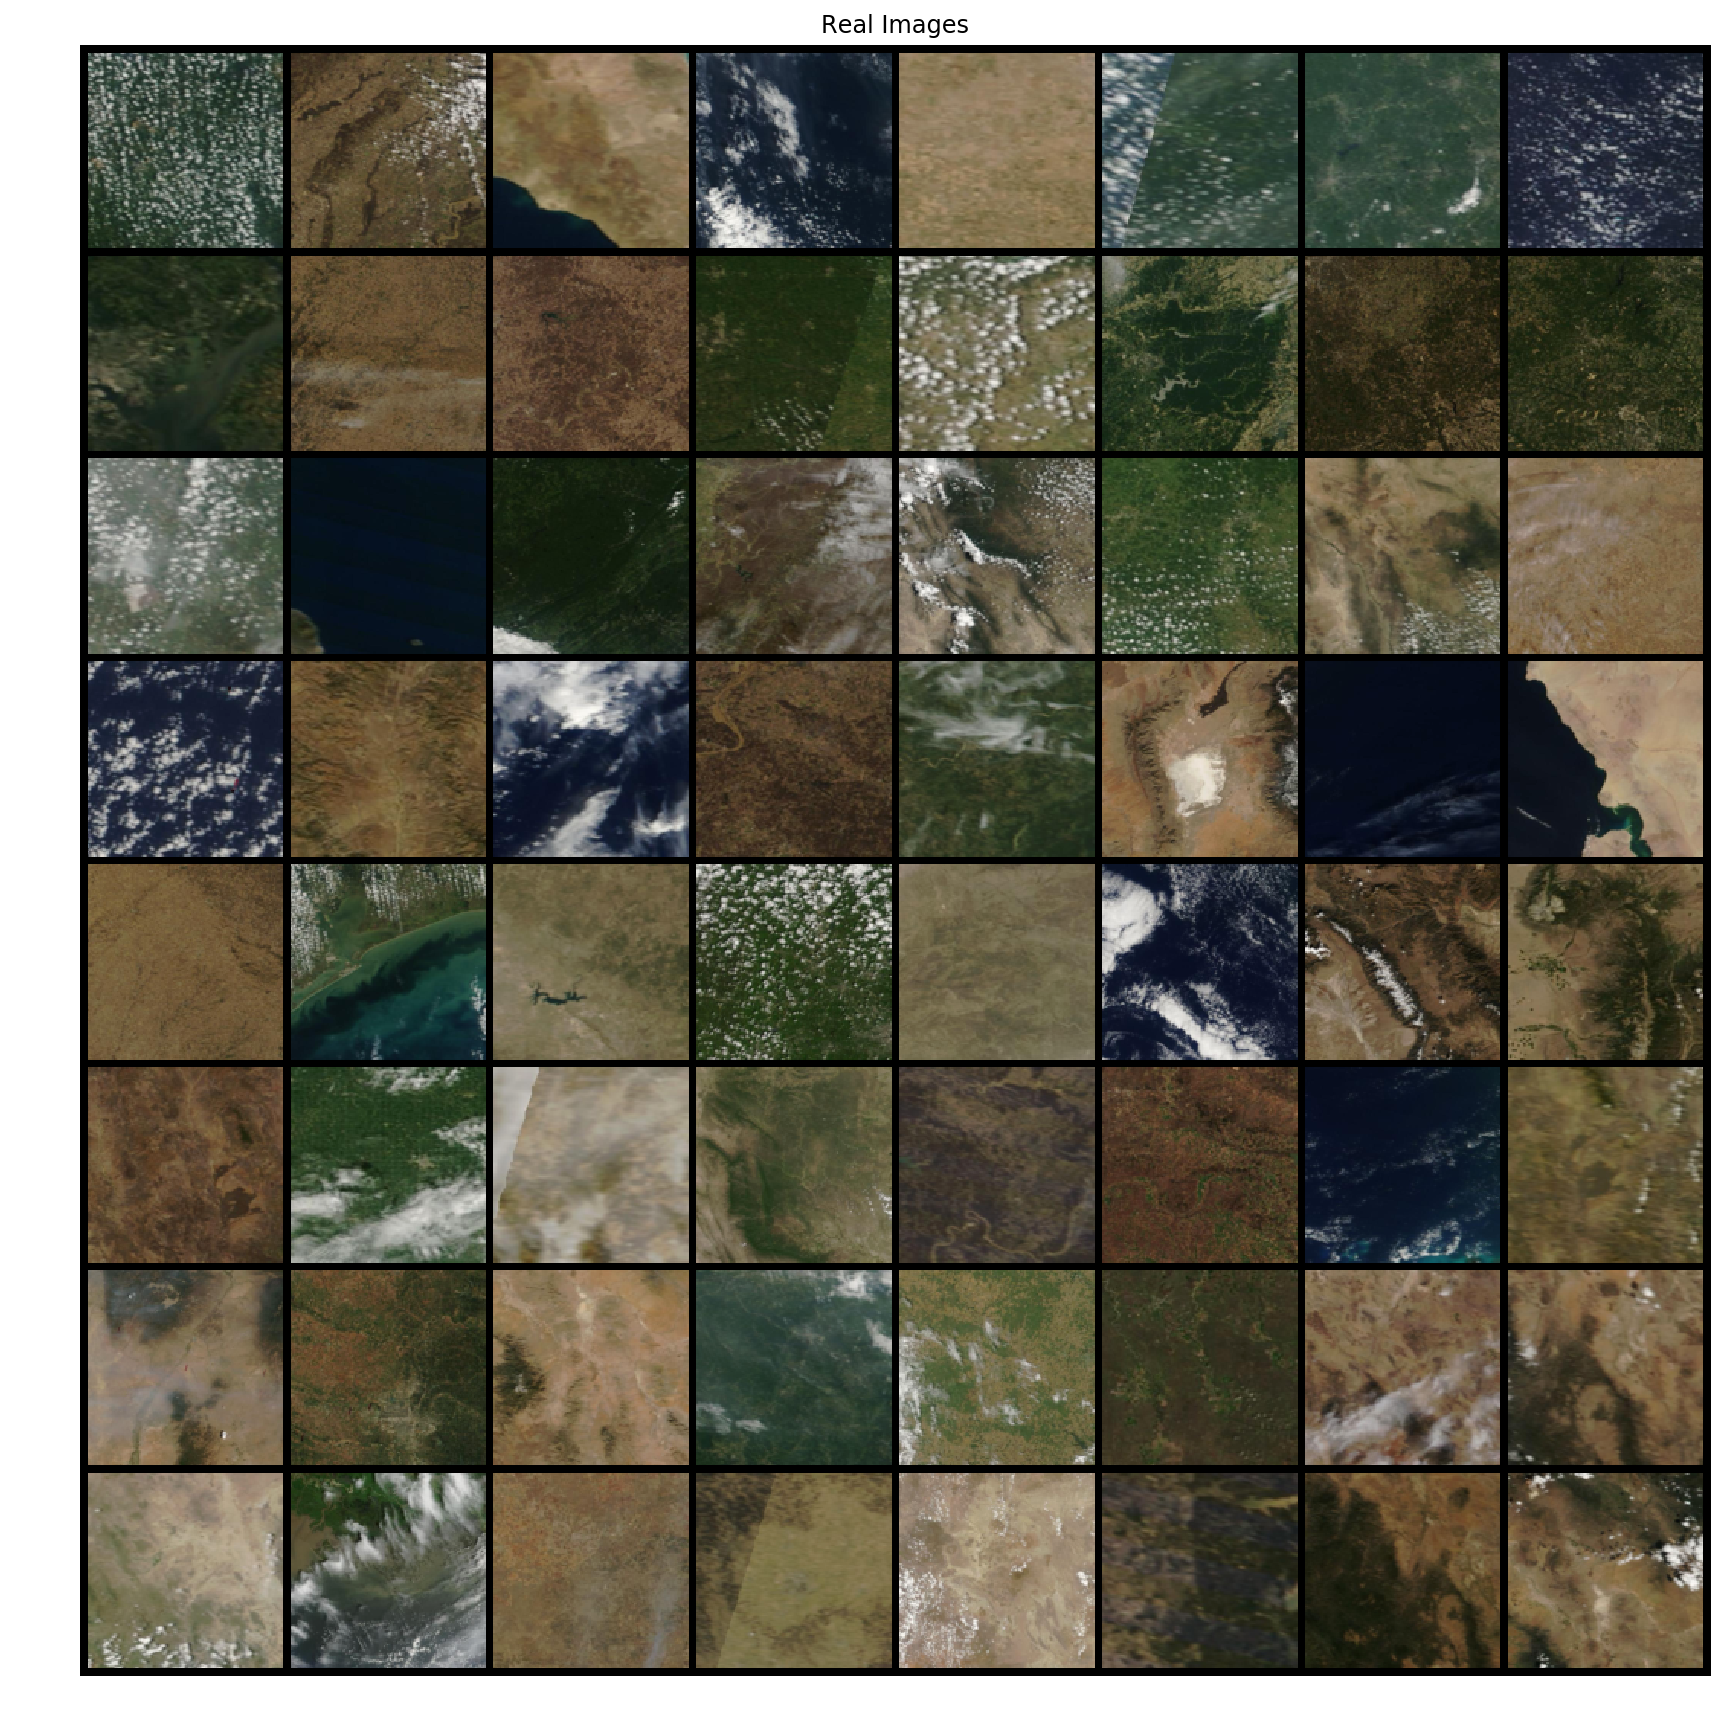

In [18]:
def get_dataset(name, root_dir=None, resolution=128):
    url = dset.data_urls[name]['tar']
    data_dir = dset.load_data_from_url(url, root_dir)
    return dset.ImageFolder(root=data_dir,
                            transform=transforms.Compose([
                                transforms.CenterCropLongEdge(),
                                transforms.Resize(resolution),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ]))

dataset = get_dataset(config['dataset'],
                      root_dir=config['data_root'],
                      resolution=config['resolution'])

dataloader = torch.utils.data.DataLoader(dataset,
                                         shuffle=config['shuffle'],
                                         batch_size=config['batch_size'],
                                         num_workers=config['num_workers'])
vutils.visualize_data(dataloader)

First, we will need to organize and preprocess the training data that will serve as the 'real' examples presented to the discriminator. If you are training an unconditional GAN with only a single class of images, it would be enough to simply store all of your examples in a directory like so:

    satellite_images/34_-77_2016-02-28.png
    satellite_images/34_-77_2014-06-29.png
    satellite_images/36_-75_2008-07-13.png
    satellite_images/30_-84_2010-07-11.png
    satellite_images/27_-97_2010-07-18.png
    
If you are training a class-conditional GAN such as SA-GAN or BigGAN, it is fairly common to store images organized as so:

    root/dogball/xxx.png
    root/dogball/xxy.png
    root/dogball/xxz.png

    root/cat/123.png
    root/cat/nsdf3.png
    root/cat/asd932_.png

### Prepare data as single HDF5 file (optional, for additional performance)

If your dataset consists of large, high-resolution images, then repeatedly applying transforms to the raw images (cropping, resizing) results in many wasted CPU cycles. Furthermore, increasing your batchsize puts additional I/O strain on your filesystem. Together, these factors may produce a dataloading bottleneck where your GPUs consume data faster than your system can produce it. To remedy this, you may choose to prepare a pre-processed HDF5 version of your target dataset using the utilities provided. Moreover, if I/O still appears to be the bottleneck, you may choose to load the entire dataset into RAM by setting `load_in_mem` dataset kwargs to `True` (if your system can support this).

# Build Model

Notable Layers

GBlock
DBlock
Spectral Normalization
Self-Attention
Class-Conditional Batch Norm


In [28]:
# Generator Code

class GBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU(True)
        
    def forward(self, input):
        """Forward method of GBlock.
        
        This block increases the spatial resolution by 2:
        
            input:  [batch_size, in_channels, H, W]
            output: [batch_size, out_channels, 2*H, 2*W]
        """
        
        x = self.conv(input)
        x = self.bn(x)
        out = self.act(x)
        return out
    

class Generator(nn.Module):
    
    # Maps output resoluton to number of GBlocks.
    res2blocks = {
        32: 3,
        64: 4,
        128: 5,
        256: 6,
    }
    
    def __init__(self, dim_z=128, resolution=128, G_ch=64, 
                block=GBlock):
        super(Generator, self).__init__()
        
        self.G_ch = G_ch
        self.dim_z = dim_z

        self.num_blocks = self.res2blocks[resolution]
        self.ch_nums = [2**i for i in range(self.num_blocks)]
        self.ch_nums += self.ch_nums[-1:]
        self.ch_nums = list(reversed(self.ch_nums))
        
        self.linear = nn.Linear(dim_z, G_ch * self.ch_nums[0] * 4**2)
        self.GBlocks = nn.Sequential(*[
            block(G_ch * in_c, G_ch * out_c)
            for in_c, out_c in zip(self.ch_nums, self.ch_nums[1:])
        ])
        self.out = nn.Conv2d(G_ch * 1, 3, 3, padding=1)  # RGB image has 3 channels
        self.tanh = nn.Tanh()                            # "Squashes" out to be in range[-1, 1]
    
    def forward(self, x):
        x = self.linear(x)
        x = x.view(x.size(0), -1, 4, 4)
        x = self.GBlocks(x)
        return self.tanh(self.out(x))
    
dim_z = 128
z = torch.rand(10, config['dim_z'])
G = Generator(dim_z=config['dim_z'], resolution=config['resolution'])
print(G)
print('output shape:', G(z).shape)

Generator(
  (linear): Linear(in_features=120, out_features=16384, bias=True)
  (GBlocks): Sequential(
    (0): GBlock(
      (conv): ConvTranspose2d(1024, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace)
    )
    (1): GBlock(
      (conv): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace)
    )
    (2): GBlock(
      (conv): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU(inplace)
    )
    (3): GBlock(
      (conv): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e

In [30]:
class DBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.2, inplace=True)
        
    def forward(self, x):
        """Forward method of DBlock.
        
        This block decreases the spatial resolution by 2:
        
            input:  [batch_size, in_channels, H, W]
            output: [batch_size, out_channels, H/2, W/2]
        """
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x
    

class Discriminator(nn.Module):
    
    # Maps output resoluton to number of DBlocks.
    res2blocks = {
        32: 3,
        64: 4,
        128: 5,
        256: 6,
    }
    
    def __init__(self, resolution=128, D_ch=64, block=DBlock):
        super().__init__()
        self.D_ch = D_ch
        self.num_blocks = self.res2blocks[resolution]
        self.fnums = [2**i for i in range(self.num_blocks)]
        self.input_layer = nn.Conv2d(3, D_ch, 3, padding=1)
        
        self.DBlocks = nn.Sequential(*[
            block(D_ch * in_c, D_ch * out_c)
            for in_c, out_c in zip(self.fnums, self.fnums[1:])
        ])
        
        self.out = nn.Conv2d(D_ch * self.fnums[-1], 1, 3, 1, 0)
        self.act = nn.Sigmoid()
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.DBlocks(x)
        x = self.act(torch.mean(self.out(x), [2, 3]))
        return x


x = torch.rand(10, 3, config['resolution'], config['resolution'])
D = Discriminator(resolution=config['resolution'])
print(D)
print('output shape:', D(x).shape)

Discriminator(
  (input_layer): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (DBlocks): Sequential(
    (0): DBlock(
      (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.2, inplace)
    )
    (1): DBlock(
      (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.2, inplace)
    )
    (2): DBlock(
      (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): LeakyReLU(negative_slope=0.2, inplace)
    )
    (3): DBlock(
      (conv): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(

In [7]:
# MAIN TRAINING FUNCTION

In [8]:
def GAN_training_function(G, D, GD, z_, y_, ema, state_dict, config):
    def train(x, y):
        G.optim.zero_grad()
        D.optim.zero_grad()
        # How many chunks to split x and y into?
        x = torch.split(x, config['batch_size'])
        y = torch.split(y, config['batch_size'])
        counter = 0

        # Optionally toggle D and G's "require_grad"
        if config['toggle_grads']:
            utils.toggle_grad(D, True)
            utils.toggle_grad(G, False)

        ###############################################################
        #                    TRAIN DISCRIMINATOR
        ###############################################################
        for step_index in range(config['num_D_steps']):
            # If accumulating gradients, loop multiple times before an optimizer step
            for accumulation_index in range(config['num_D_accumulations']):
                z_.sample_(), y_.sample_()
                D_fake, D_real = GD(z_[:config['batch_size']], y_[:config['batch_size']],
                                    x[counter], y[counter], train_G=False,
                                    split_D=config['split_D'])

                # Compute components of D's loss, average them, and divide by
                # the number of gradient accumulations.
                D_loss_real, D_loss_fake = losses.discriminator_loss(D_fake, D_real)
                D_loss = (D_loss_real + D_loss_fake) / float(config['num_D_accumulations'])
                D_loss.backward()
                counter += 1

            # Optionally apply ortho reg in D.
            if config['D_ortho'] > 0.0:
                # Debug print to indicate we're using ortho reg in D.
                print('using modified ortho reg in D')
                utils.ortho(D, config['D_ortho'])

            D.optim.step()

        # Optionally toggle "requires_grad"
        if config['toggle_grads']:
            utils.toggle_grad(D, False)
            utils.toggle_grad(G, True)

        # Zero G's gradients by default before training G, for safety.
        G.optim.zero_grad()

        ###############################################################
        #                    TRAIN GENERATOR
        ###############################################################
        # If accumulating gradients, loop multiple times.
        for accumulation_index in range(config['num_G_accumulations']):
            z_.sample_(), y_.sample_()
            D_fake = GD(z_, y_, train_G=True, split_D=config['split_D'])
            G_loss = losses.generator_loss(D_fake) / float(config['num_G_accumulations'])
            G_loss.backward()

        # Optionally apply modified ortho reg in G.
        if config['G_ortho'] > 0.0:
            print('using modified ortho reg in G')  # Debug print to indicate we're using ortho reg in G.
            # Don't ortho reg shared, it makes no sense. Really we should blacklist any embeddings for this...
            utils.ortho(G, config['G_ortho'],
                        blacklist=[param for param in G.shared.parameters()])
        G.optim.step()

        # If we have an ema, update it, regardless of if we test with it or not.
        if config['ema']:
            ema.update(state_dict['itr'])

        out = {'G_loss': float(G_loss.item()),
               'D_loss_real': float(D_loss_real.item()),
               'D_loss_fake': float(D_loss_fake.item())}
        return out
    return train
